# 실습 환경설정

In [ ]:
# 학번, 이름 화면에 출력
id = '20197132'
name = '주준하'
print(id, name)

20197132 주준하


In [ ]:
# 구글 드라이브 사용 권한 설정
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 과제 파일 저장한 폴더 위치 설정 (폴더 위치에 맞춰서 변경할 것)
import os
colab_path = "/gdrive/My Drive/Colab Notebooks/CV_과제2"  # 경로예시: 구글드라이브/내 드라이브/Colab Notebooks/과제폴더명

In [ ]:
!pip install jpegio  # jpeg DCT 계수, 양자화 테이블값 획득하기 위한 패키지 설치

     |████████████████████████████████| 73.5 MB 136 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for jpegio: filename=jpegio-0.2.8-cp37-cp37m-linux_x86_64.whl size=917390 sha256=e8660f0d953998d44021fed7e835effffad8f850eabee969e917e33415855a3f
  Stored in directory: /root/.cache/pip/wheels/cd/d8/36/f3925fc7268d5cfe7efd97e7b8c9d7cca68635694c48a49bc6
Successfully built jpegio


In [ ]:
import jpegio
import numpy as np
from scipy import fftpack
import cv2
import matplotlib.pyplot as plt

# JPEG 실습내용

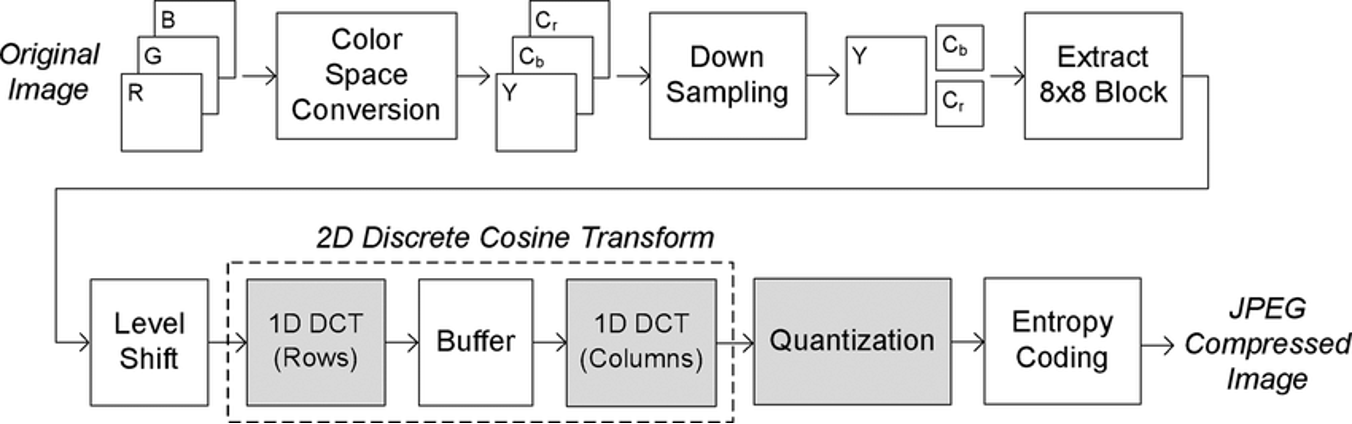

## JPEG 관련 함수 정의

In [ ]:
def idct2d(f):
    x1 = fftpack.idct(f, norm="ortho")
    x2 = fftpack.idct(x1.transpose((0, 1, 2, 4, 3)), norm="ortho")
    return x2.transpose((0, 1, 2, 4, 3))

In [ ]:
def ycbcr2rgb(im):
    """
    im: numpy array H x W x C, range [0, 255]
    C: [Y, Cb, Cr]
    output: numpy array H x W x C, range [0, 255]
    """
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float64)
    rgb = rgb.dot(xform.T)
    return np.array(rgb, dtype=im.dtype)

In [ ]:
def jpg444recon(path):
    image = jpegio.read(path)
    image.quant_tables.append(image.quant_tables[1])  # Cr 양자화 테이블 채널 추가(Cb와 동일)
    coef_arrays = image.coef_arrays  # YCbCr 양자화된 DCT 계수 (3, 512, 512)
    quant_tables = image.quant_tables  # YCbCr 양자화 테이블 (3, 8, 8)
    h, w = coef_arrays[0].shape
    image_q = np.array(quant_tables).astype(np.int16).reshape((-1, 1, 1, 8, 8))
    image_c = np.array(coef_arrays)
    image_c = image_c.reshape((3, h // 8, 8, w // 8, 8), order='C').transpose(0, 1, 3, 2, 4)  # 8x8 block 단위로 채널 분리
    deq = image_c * image_q  # 양자화 복원: 양자화된 계수 * 양자화 테이블
    image_ycbcr = idct2d(deq).transpose(0, 1, 3, 2, 4).reshape(3, h, w)  # Inverse DCT2D 수행
    image_ycbcr = image_ycbcr.transpose(1, 2, 0)  # 채널 변경: CxHwW -> HxWxC 
    image_ycbcr[:, :, 0] += 128  # 밝기 Level Shift 복원 (128 더하기)
    image_rgb = np.clip(ycbcr2rgb(image_ycbcr), 0, 255)  # RGB 픽셀값 범위로 값 절삭
    image_rgb = image_rgb.astype(np.uint8)  # UINT8로 타입 변환 (값 범위 0~255)

    return image_rgb

In [ ]:
img_color_recon = jpg444recon(os.path.join(colab_path, '00016.jpeg'))  # jpegio로 JPEG 이미지 읽어서 RGB 픽셀값 복원하기

In [ ]:
img_color_cv = cv2.imread(os.path.join(colab_path, '00016.jpeg'), cv2.IMREAD_COLOR)  # OpenCV로 Color 이미지 읽기

In [ ]:
img_color_cv.dtype  # uint8: 정수형 [0, 255]

dtype('uint8')

In [ ]:
img_color_cv.shape  # 이미지 크기 확인

(512, 512, 3)

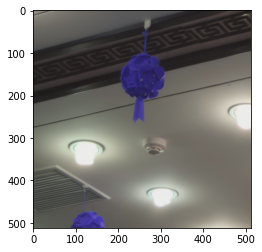

In [ ]:
plt.imshow(img_color_cv)  # 이미지 화면 출력, OpenCV 기본 컬러순서: B, G, R

In [ ]:
img_color_cv = cv2.cvtColor(img_color_cv, cv2.COLOR_BGR2RGB)  # 컬러 채널 순서 변경: BGR -> RGB

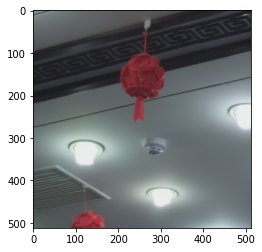

In [ ]:
plt.imshow(img_color_cv)  # 이미지 화면 출력

In [ ]:
img_color_recon = jpg444recon(os.path.join(colab_path, '00016.jpeg'))  # jpegio로 JPEG 이미지 읽어서 RGB 픽셀값 복원하기

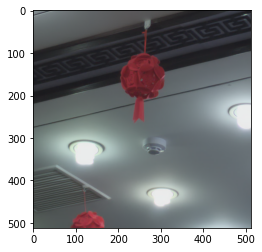

In [ ]:
plt.imshow(img_color_recon)  # 이미지 화면 출력

# 실습 과제

JPEG 압축은 압축효율을 위해 YUV420 포맷을 기본값으로 사용함

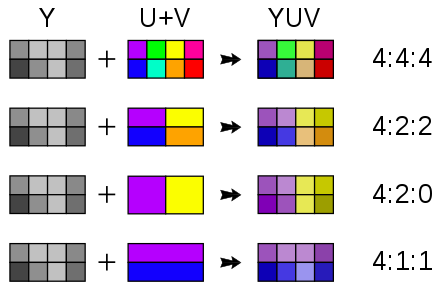

문제: YUV420으로 압축한 JPEG 이미지의 픽셀값을 복원하는 함수를 작성하시오.
- YUV420: 압축 효율을 위해 색상값(Cb, Cr)을 가로 1/2배, 세로 1/2배로 subsampling한 이미지 형식
- jpeg444recon 함수 참고할 것
- OpenCV 등 다른 영상처리 패키지 사용 불가
- 힌트: Y, Cb, Cr채널 별로 픽셀값 복원하고 크기 맞추기(cv2.resize) -> YCbCr 3개 채널로 합치기 -> RGB 포맷으로 바꾸기

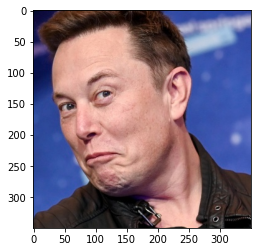

In [ ]:
img_color_cv = cv2.imread(os.path.join(colab_path, 'elon-face.jpg'), cv2.IMREAD_COLOR)  # OpenCV로 Color 이미지 읽기
img_color_cv = cv2.cvtColor(img_color_cv, cv2.COLOR_BGR2RGB)  # 컬러 채널 순서 변경: BGR -> RGB
plt.imshow(img_color_cv)  # 이미지 화면 출력

In [ ]:
def idct2d(f):
    x1 = fftpack.idct(f, norm="ortho")
    x2 = fftpack.idct(x1.transpose((0, 1, 3, 2)), norm="ortho")
    return x2.transpose((0, 1, 3, 2))
    
def jpg420recon(path):
    image = jpegio.read(path)
    # 코드 작성 부분
    image.quant_tables.append(image.quant_tables[1])  # Cr 양자화 테이블 채널 추가(Cb와 동일)
    coef_arrays = image.coef_arrays  # YCbCr 양자화된 DCT 계수 (0, 352, 352), (1, 176, 176), (2, 176, 176)
    quant_tables = image.quant_tables  # YCbCr 양자화 테이블 3, 8, 8
    
    h, w = coef_arrays[0].shape
    image_q = np.array(quant_tables).astype(np.int16).reshape((-1, 1, 1, 8, 8))

    coef_y = coef_arrays[0].reshape((h // 8, 8, w // 8, 8), order='C').transpose(0, 2, 1, 3)  #image_y.shape = (44, 44, 8, 8)
    coef_cb = coef_arrays[1].reshape(( (h // 2) // 8, 8, (w // 2) // 8, 8), order='C').transpose(0, 2, 1, 3) #image_cb.shape = (22, 22, 8, 8)
    coef_cr = coef_arrays[2].reshape(( (h // 2) // 8, 8, (w // 2) // 8, 8), order='C').transpose(0, 2, 1, 3) #image_cr.shape = (22, 22, 8, 8)
    #복원
    image_y = (coef_y * image_q[0])
    image_cb = (coef_cr * image_q[1])
    image_cr = (coef_cb * image_q[2])
    #각 채널 idct
    idct_y = idct2d(image_y).transpose(0, 2, 1, 3).reshape(h, w) #idct_y.shape = (352, 352)
    idct_cb = idct2d(image_cb).transpose(0, 2, 1, 3).reshape(h // 2, w // 2) #idct_cb.shape = (176, 176)
    idct_cr = idct2d(image_cr).transpose(0, 2, 1, 3).reshape(h // 2, w // 2) #idct_cr.shape = (176, 176)

    image_ycbcr = np.zeros((3, h, w))
    image_ycbcr[0] = idct_y
    for i in range(0, h, 2):
        image_ycbcr[1][i][0::2]     = idct_cb[i // 2]
        image_ycbcr[1][i][1::2]     = idct_cb[i // 2]
        image_ycbcr[1][i + 1][0::2] = idct_cb[i // 2]
        image_ycbcr[1][i + 1][1::2] = idct_cb[i // 2]

        image_ycbcr[2][i][0::2]     = idct_cr[i // 2]
        image_ycbcr[2][i][1::2]     = idct_cr[i // 2]
        image_ycbcr[2][i + 1][0::2] = idct_cr[i // 2]
        image_ycbcr[2][i + 1][1::2] = idct_cr[i // 2]

    image_ycbcr = image_ycbcr.transpose(1, 2, 0)  # 채널 변경: CxHwW -> HxWxC 
    image_ycbcr[:, :, 0] += 128  # 밝기 Level Shift 복원 (128 더하기)
    image_rgb = np.clip(ycbcr2rgb(image_ycbcr), 0, 255)  # RGB 픽셀값 범위로 값 절삭
    image_rgb = image_rgb.astype(np.uint8)  # UINT8로 타입 변환 (값 범위 0~255)
    image_rgb = image_rgb[:, :, ::-1]
    return image_rgb

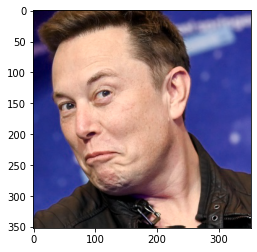

In [ ]:
# 코드 결과 확인 부분: 수정하지 말 것
img_color_recon420 = jpg420recon(os.path.join(colab_path, 'elon-face.jpg'))  # jpegio로 JPEG 이미지 읽어서 RGB 픽셀값 복원하기
plt.imshow(img_color_recon420)  # 이미지 화면 출력